In [1]:
# ==== Cell 1: Setup & Imports ====
import os, math, random, json, time, inspect
from dataclasses import dataclass
from typing import List, Dict, Tuple

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cuda


In [2]:
# ==== Cell 2: Vocabulary & Tokenization ====
AA = "ACDEFGHIKLMNPQRSTVWY"
PAD, BOS, EOS = "_", "^", "*"

# Put PAD/BOS/EOS first for convenience (pad_idx = 0)
VOCAB = [PAD, BOS, EOS] + list(AA)
stoi = {c:i for i,c in enumerate(VOCAB)}
itos = {i:c for c,i in stoi.items()}
PAD_IDX, BOS_IDX, EOS_IDX = stoi[PAD], stoi[BOS], stoi[EOS]

def sanitize_seq(seq: str) -> str:
    return "".join([c for c in str(seq).upper() if c in AA])

# MAX_LEN set after loading data to fit longest sequence
MAX_LEN = 64  # placeholder; will update in Cell 4

def encode_seq(seq: str) -> List[int]:
    s = sanitize_seq(seq)[:MAX_LEN-2]
    ids = [BOS_IDX] + [stoi[c] for c in s] + [EOS_IDX]
    if len(ids) < MAX_LEN:
        ids += [PAD_IDX] * (MAX_LEN - len(ids))
    return ids

def decode_ids(ids: List[int]) -> str:
    out = []
    for i in ids:
        ch = itos[int(i)]
        if ch == EOS: break
        if ch in (BOS, PAD): continue
        out.append(ch)
    return "".join(out)


In [3]:
# ==== Cell 3: Physicochemical properties & conditioning vector ====

PKA_NTERM = 8.6
PKA_CTERM = 3.6
PKA_SIDE = {'D':3.9,'E':4.2,'H':6.0,'C':8.3,'Y':10.1,'K':10.5,'R':12.5}

KD = {'I':4.5,'V':4.2,'L':3.8,'F':2.8,'C':2.5,'M':1.9,'A':1.8,'G':-0.4,'T':-0.7,'S':-0.8,
      'W':-0.9,'Y':-1.3,'P':-1.6,'H':-3.2,'E':-3.5,'Q':-3.5,'D':-3.5,'N':-3.5,'K':-3.9,'R':-4.5}

CF_HELIX = {'A':1.42,'C':0.70,'D':1.01,'E':1.51,'F':1.13,'G':0.57,'H':1.00,'I':1.08,
            'K':1.16,'L':1.21,'M':1.45,'N':0.67,'P':0.57,'Q':1.11,'R':0.98,'S':0.77,
            'T':0.83,'V':1.06,'W':1.08,'Y':0.69}

WW_IF = {'A':0.17,'R':0.81,'N':0.42,'D':1.23,'C':-0.24,'Q':0.58,'E':2.02,'G':0.01,'H':0.96,'I':-0.31,
         'L':-0.56,'K':0.99,'M':-0.23,'F':-1.13,'P':0.45,'S':0.13,'T':0.14,'W':-1.85,'Y':-0.94,'V':-0.07}

def gravy(seq: str) -> float:
    return 0.0 if not seq else float(np.mean([KD.get(a,0.0) for a in seq]))

def net_charge(seq: str, pH: float = 7.0) -> float:
    if not seq: return 0.0
    nterm = 1.0 / (1.0 + 10**(pH - PKA_NTERM))
    cterm = -1.0 / (1.0 + 10**(PKA_CTERM - pH))
    charge = nterm + cterm
    for a in seq:
        if a in ('D','E','C','Y'):
            charge += -1.0 / (1.0 + 10**(PKA_SIDE[a] - pH))
        elif a in ('H','K','R'):
            charge +=  1.0 / (1.0 + 10**(pH - PKA_SIDE[a]))
    return float(charge)

def helix_fraction(seq: str) -> float:
    if not seq: return 0.0
    vals = [CF_HELIX.get(a,1.0) for a in seq]
    return float(np.clip((np.mean(vals)-0.57)/(1.51-0.57), 0.0, 1.0))

def hydrophobic_moment(seq: str, window: int = 18, theta_deg: float = 100.0) -> float:
    if not seq: return 0.0
    theta = math.radians(theta_deg)
    hvals = [KD.get(a,0.0) for a in seq]
    max_mu = 0.0
    for i in range(0, max(1,len(seq)-window+1)):
        hv = hvals[i:i+window]
        x = sum(hv[k]*math.cos(theta*k) for k in range(len(hv)))
        y = sum(hv[k]*math.sin(theta*k) for k in range(len(hv)))
        mu = math.sqrt(x*x + y*y) / max(1,len(hv))
        max_mu = max(max_mu, mu)
    return float(max_mu)

def amphipathicity(seq: str) -> float:
    return float(helix_fraction(seq) * hydrophobic_moment(seq))

def membrane_interfacial_energy(seq: str) -> float:
    if not seq: return 0.0
    return float(np.mean([WW_IF.get(a,0.0) for a in seq]))

def peptide_properties(seq: str) -> Dict[str, float]:
    s = sanitize_seq(seq)
    return dict(
        sequence=s,
        length=len(s),
        net_charge=net_charge(s),
        gravy=gravy(s),
        helix_fraction=helix_fraction(s),
        hydrophobic_moment=hydrophobic_moment(s),
        amphipathicity=amphipathicity(s),
        membrane_energy=membrane_interfacial_energy(s),
    )

def conditioning_vector(props: Dict[str, float]) -> np.ndarray:
    # Scaled 0..1 for stability; depends on MAX_LEN
    vec = np.array([
        min(props["length"], MAX_LEN-2) / (MAX_LEN-2),                   # length
        np.clip((props["net_charge"] + 5.0) / 15.0, 0.0, 1.0),           # charge
        np.clip((props["gravy"] + 2.0) / 4.0, 0.0, 1.0),                 # GRAVY
        np.clip(props["helix_fraction"], 0.0, 1.0),                      # helix%
        np.clip(props["hydrophobic_moment"]/5.0, 0.0, 1.0),              # μH
        np.clip(props["amphipathicity"]/5.0, 0.0, 1.0),                  # amphipathicity
        np.clip((props["membrane_energy"] + 5.0)/10.0, 0.0, 1.0),        # WW_IF energy
    ], dtype=np.float32)
    return vec


In [4]:
# ==== Cell 4: Load AMPS2.xlsx (expects 'Sequence' column) ====
DATA_PATH = "AMPS2.xlsx"
df_in = pd.read_excel(DATA_PATH)
if "Sequence" not in df_in.columns:
    raise ValueError("AMPS2.xlsx must contain a column named 'Sequence'.")

train_sequences = [sanitize_seq(s) for s in df_in["Sequence"].dropna().tolist()]
train_sequences = [s for s in train_sequences if len(s) > 0]
if not train_sequences:
    raise ValueError("No valid sequences found after sanitization.")

# Adjust MAX_LEN to longest seq + BOS/EOS (cap pos embedding later)
needed = max(len(s) for s in train_sequences) + 2
if needed > MAX_LEN:
    MAX_LEN = needed
print(f"Loaded {len(train_sequences)} sequences; MAX_LEN set to {MAX_LEN}")


Loaded 594 sequences; MAX_LEN set to 68


In [5]:
# ==== Cell 5: Dataset, collate, loaders ====
@dataclass
class PepItem:
    x: torch.Tensor      # full sequence ids [BOS ... EOS PAD...]
    y_in: torch.Tensor   # x[:, :-1]
    y_out: torch.Tensor  # x[:, 1:]
    c: torch.Tensor      # conditioning vector

class PepDataset(Dataset):
    def __init__(self, seqs: List[str]):
        self.seqs = seqs
        self.enc = [encode_seq(s) for s in self.seqs]
        self.props = [peptide_properties(s) for s in self.seqs]
        self.cond  = [conditioning_vector(p) for p in self.props]
    def __len__(self): return len(self.seqs)
    def __getitem__(self, idx) -> PepItem:
        ids = torch.tensor(self.enc[idx], dtype=torch.long)
        y_in  = ids[:-1].clone()
        y_out = ids[1:].clone()
        c     = torch.tensor(self.cond[idx], dtype=torch.float32)
        return PepItem(ids, y_in, y_out, c)

def pep_collate(batch: List[PepItem]):
    x    = torch.stack([b.x    for b in batch], dim=0)
    y_in = torch.stack([b.y_in for b in batch], dim=0)
    y_ot = torch.stack([b.y_out for b in batch], dim=0)
    c    = torch.stack([b.c    for b in batch], dim=0)
    return type("PepBatch", (), {"x": x, "y_in": y_in, "y_out": y_ot, "c": c})

def make_loaders(seqs: List[str], batch=64, val_frac=0.3, shuffle=True):
    n = len(seqs)
    idx = np.arange(n)
    if shuffle: np.random.shuffle(idx)
    n_val = max(1, int(n*val_frac)) if n>1 else 0
    va_idx, tr_idx = idx[:n_val], idx[n_val:]
    tr = [seqs[i] for i in tr_idx] if len(tr_idx)>0 else seqs
    va = [seqs[i] for i in va_idx] if n_val>0 else seqs
    ds_tr, ds_va = PepDataset(tr), PepDataset(va)
    dl_tr = DataLoader(ds_tr, batch_size=min(batch, max(1,len(ds_tr))),
                       shuffle=True,  drop_last=(len(ds_tr)>=batch), collate_fn=pep_collate)
    dl_va = DataLoader(ds_va, batch_size=min(batch, max(1,len(ds_va))),
                       shuffle=False, drop_last=False, collate_fn=pep_collate)
    return ds_tr, ds_va, dl_tr, dl_va

ds_tr, ds_va, dl_tr, dl_va = make_loaders(train_sequences, batch=64, val_frac=0.3)
print(f"Train={len(ds_tr)} | Val={len(ds_va)}")


Train=416 | Val=178


In [6]:
# ==== Cell 6: Improved conditional VAE (LSTM + FiLM) ====
class PeptideCVAE(nn.Module):
    def __init__(self, vocab_size, d_model=256, z_dim=64, c_dim=7,
                 pad_idx=PAD_IDX, bos_idx=BOS_IDX, eos_idx=EOS_IDX, max_pos=1024):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.z_dim = z_dim
        self.c_dim = c_dim
        self.pad_idx = pad_idx
        self.bos_idx = bos_idx
        self.eos_idx = eos_idx

        # Embeddings
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb   = nn.Embedding(max(max_pos, MAX_LEN), d_model)

        # Encoder (BiLSTM)
        self.encoder = nn.LSTM(d_model, d_model, batch_first=True, bidirectional=True)
        self.enc_proj = nn.Linear(2*d_model + c_dim, 2*z_dim)  # -> [mu, logvar]

        # Latent -> decoder init
        self.lat_proj = nn.Linear(z_dim, d_model)

        # Decoder (LSTM)
        self.decoder = nn.LSTM(d_model, d_model, batch_first=True)

        # FiLM conditioning in decoder
        self.film = nn.Linear(c_dim, 2*d_model)

        # Output projection
        self.out_proj = nn.Linear(d_model, vocab_size)

        # Aux property head (multi-task)
        self.prop_head = nn.Sequential(nn.Linear(z_dim, 128), nn.ReLU(), nn.Linear(128, c_dim))

    def encode(self, x, c):
        B, T = x.size()
        pos = torch.arange(T, device=x.device).unsqueeze(0).expand(B, T)
        h = self.token_emb(x) + self.pos_emb(pos)
        h, _ = self.encoder(h)
        h = h.mean(dim=1)  # pooled
        hc = torch.cat([h, c], dim=-1)
        mu, logvar = self.enc_proj(hc).chunk(2, dim=-1)
        return mu, logvar

    @staticmethod
    def reparameterize(mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, y_in, z, c):
        B, T = y_in.size()
        pos = torch.arange(T, device=y_in.device).unsqueeze(0).expand(B, T)
        h = self.token_emb(y_in) + self.pos_emb(pos)
        zvec = self.lat_proj(z).unsqueeze(1).expand(B, T, -1)
        h = h + zvec
        gamma, beta = self.film(c).chunk(2, dim=-1)  # (B,D) each
        h = h * (1 + gamma.unsqueeze(1)) + beta.unsqueeze(1)
        out, _ = self.decoder(h)
        return self.out_proj(out)

    def forward(self, x, c, y_in, y_out, beta, p_uncond=0.15, token_drop=0.1, free_bits=0.5, label_smoothing=0.05):
        # Classifier-Free Guidance (drop conditioning during train)
        if self.training and torch.rand(1).item() < p_uncond:
            c_used = torch.zeros_like(c)
        else:
            c_used = c

        # Token dropout on decoder input (before decode)
        if self.training and token_drop > 0:
            drop_mask = (torch.rand_like(y_in.float()) < token_drop) & (y_in != self.pad_idx) & (y_in != self.bos_idx)
            y_in = torch.where(drop_mask, torch.full_like(y_in, self.pad_idx), y_in)

        mu, logvar = self.encode(x, c_used)
        z = self.reparameterize(mu, logvar)
        logits = self.decode(y_in, z, c_used)

        # Reconstruction loss with optional smoothing fallback
        try:
            rec = F.cross_entropy(logits.reshape(-1, self.vocab_size),
                                  y_out.reshape(-1),
                                  ignore_index=self.pad_idx,
                                  label_smoothing=label_smoothing)
        except TypeError:
            rec = F.cross_entropy(logits.reshape(-1, self.vocab_size),
                                  y_out.reshape(-1),
                                  ignore_index=self.pad_idx)

        # Free-bits KL
        kld_per_dim = -0.5 * (1 + logvar - mu.pow(2) - logvar.exp())  # (B, z_dim)
        kld = torch.mean(torch.clamp(kld_per_dim, min=free_bits).sum(dim=1))

        # Auxiliary property loss (predict c from latent)
        c_hat = self.prop_head(mu)  # use mu as latent summary
        prop_loss = F.mse_loss(c_hat, c)

        loss = rec + beta * kld + 0.2 * prop_loss
        return loss, rec, kld, prop_loss

    @torch.no_grad()
    def sample(self, z, c, max_len=64, w=1.8, target_len=50):
        """Greedy decode with CFG mixing and EOS encouragement."""
        self.eval()
        B = z.size(0)
        cur = torch.full((B,1), self.bos_idx, dtype=torch.long, device=z.device)
        finished = torch.zeros(B, dtype=torch.bool, device=z.device)
        outs = []

        for t in range(max_len):
            # Unconditional vs conditional logits
            logits_u = self.decode(cur, z, torch.zeros_like(c))
            logits_c = self.decode(cur, z, c)
            step = logits_u[:,-1,:] + w*(logits_c[:,-1,:] - logits_u[:,-1,:])

            # EOS encouragement if exceeding target
            if t > int(target_len) + 5 and self.eos_idx is not None:
                step[:, self.eos_idx] += 0.5

            next_tok = torch.argmax(step, dim=-1).unsqueeze(1)
            outs.append(next_tok)
            cur = torch.cat([cur, next_tok], dim=1)
            finished |= (next_tok.squeeze(1) == self.eos_idx)
            if finished.all(): break

        outs = torch.cat(outs, dim=1) if outs else torch.full((B,0), self.eos_idx, device=z.device, dtype=torch.long)
        return outs


In [7]:
# ==== Cell 7: Training loop with cyclical β and free-bits ====

@dataclass
class TrainConfig:
    epochs: int = 40
    lr: float = 3e-4
    beta_max: float = 0.3
    cycle_epochs: int = 10
    p_uncond: float = 0.15
    token_drop: float = 0.10
    free_bits: float = 0.5
    label_smoothing: float = 0.05
    grad_clip: float = 1.0

def cyc_beta(ep, beta_max=0.3, cycle=10):
    phase = (ep % cycle) / cycle
    return beta_max * phase

def train_cvae(model: PeptideCVAE, dl_tr: DataLoader, dl_va: DataLoader, cfg=TrainConfig()):
    model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    hist = []

    def run_epoch(dl, train=True, ep=0):
        model.train(train)
        totL=totR=totK=totP=0.0; steps=0
        beta = cyc_beta(ep, cfg.beta_max, cfg.cycle_epochs)
        for batch in dl:
            x    = batch.x.to(DEVICE)
            y_in = batch.y_in.to(DEVICE)
            y_ot = batch.y_out.to(DEVICE)
            c    = batch.c.to(DEVICE)

            if train: opt.zero_grad()
            loss, rec, kld, prop = model(x, c, y_in, y_ot, beta,
                                         p_uncond=cfg.p_uncond,
                                         token_drop=cfg.token_drop,
                                         free_bits=cfg.free_bits,
                                         label_smoothing=cfg.label_smoothing)
            if train:
                loss.backward()
                if cfg.grad_clip: nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
                opt.step()

            totL += float(loss.item()); totR += float(rec.item()); totK += float(kld.item()); totP += float(prop.item()); steps += 1
        return (totL/max(1,steps), totR/max(1,steps), totK/max(1,steps), totP/max(1,steps), beta)

    best_val = float("inf"); best_state=None
    for ep in range(cfg.epochs):
        trL,trR,trK,trP,beta = run_epoch(dl_tr, True, ep)
        vaL,vaR,vaK,vaP,_    = run_epoch(dl_va, False, ep)
        hist.append(dict(epoch=ep+1, train_loss=trL, train_rec=trR, train_kld=trK, train_prop=trP,
                         val_loss=vaL, val_rec=vaR, val_kld=vaK, val_prop=vaP, beta=beta))
        print(f"Ep {ep+1:03d} | TR {trL:.3f}/{trR:.3f}/{trK:.3f}/{trP:.3f} β={beta:.2f} | "
              f"VA {vaL:.3f}/{vaR:.3f}/{vaK:.3f}/{vaP:.3f}")
        if vaL < best_val:
            best_val = vaL
            best_state = {k:v.detach().cpu() for k,v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)
    return pd.DataFrame(hist)

model = PeptideCVAE(vocab_size=len(VOCAB), d_model=256, z_dim=64, c_dim=7,
                    pad_idx=PAD_IDX, bos_idx=BOS_IDX, eos_idx=EOS_IDX, max_pos=max(1024, MAX_LEN+4))
history = train_cvae(model, dl_tr, dl_va, cfg=TrainConfig())
history.head()


Ep 001 | TR 3.107/3.056/32.000/0.255 β=0.00 | VA 3.000/2.961/32.000/0.196
Ep 002 | TR 3.870/2.880/32.000/0.154 β=0.03 | VA 3.756/2.781/32.000/0.077
Ep 003 | TR 4.618/2.685/32.069/0.041 β=0.06 | VA 4.552/2.627/32.027/0.018
Ep 004 | TR 5.433/2.549/32.017/0.011 β=0.09 | VA 5.400/2.518/32.000/0.010
Ep 005 | TR 6.264/2.422/32.001/0.008 β=0.12 | VA 6.226/2.383/32.000/0.010
Ep 006 | TR 7.082/2.280/32.002/0.008 β=0.15 | VA 7.063/2.261/32.000/0.010
Ep 007 | TR 7.933/2.170/32.005/0.007 β=0.18 | VA 7.918/2.156/32.000/0.008
Ep 008 | TR 8.771/2.049/32.002/0.007 β=0.21 | VA 8.778/2.056/32.002/0.009
Ep 009 | TR 9.629/1.948/32.002/0.006 β=0.24 | VA 9.660/1.978/32.000/0.008
Ep 010 | TR 10.523/1.882/32.001/0.006 β=0.27 | VA 10.549/1.908/32.000/0.008
Ep 011 | TR 1.801/1.800/32.184/0.006 β=0.00 | VA 1.853/1.851/33.339/0.010
Ep 012 | TR 2.703/1.731/32.336/0.009 β=0.03 | VA 2.773/1.810/32.000/0.017
Ep 013 | TR 3.615/1.692/32.000/0.014 β=0.06 | VA 3.688/1.766/32.000/0.009
Ep 014 | TR 4.543/1.661/32.000/0.007

,epoch,train_loss,train_rec,train_kld,train_prop,val_loss,val_rec,val_kld,val_prop,beta
0,1,3.106608,3.055528,32.000000,0.255398,3.000208,2.960978,32.000000,0.196151,0.00
1,2,3.870360,2.879553,32.000000,0.154033,3.756421,2.781080,32.000000,0.076708,0.03
2,3,4.617881,2.685425,32.069372,0.041472,4.552237,2.627032,32.026585,0.018048,0.06
3,4,5.432921,2.549130,32.017399,0.011127,5.400085,2.518098,32.000264,0.009816,0.09
4,5,6.263659,2.421922,32.000780,0.008216,6.225502,2.383405,32.000023,0.010471,0.12


In [8]:
# ==== Cell 8: n-gram LM for plausibility & novelty proxy ====
from collections import Counter, defaultdict

def kmer_counts(seqs: List[str], k: int) -> Counter:
    c = Counter()
    for s in seqs:
        for i in range(len(s)-k+1):
            c[s[i:i+k]] += 1
    return c

def train_char_ngram_lm(seqs: List[str], n: int = 3, k_smooth: float = 0.5):
    counts = defaultdict(Counter)
    alphabet = list(AA) + [BOS, EOS]
    for s in seqs:
        s2 = BOS + s + EOS
        for i in range(len(s2)-n+1):
            ctx = s2[i:i+n-1]
            nxt = s2[i+n-1]
            counts[ctx][nxt] += 1
    table = {}
    vocab = set(alphabet)
    V = len(vocab)
    for ctx, cnt in counts.items():
        total = sum(cnt.values()) + k_smooth*V
        table[ctx] = {ch: math.log((cnt.get(ch,0)+k_smooth)/total) for ch in vocab}
    return table, vocab, n

LM_TABLE, LM_VOCAB, LM_N = train_char_ngram_lm(train_sequences, n=3, k_smooth=0.5)

def lm_neg_log_per_token(seq: str) -> float:
    s = BOS + seq + EOS
    if len(s) < LM_N: return 10.0
    logp = 0.0; count = 0
    for i in range(len(s)-LM_N+1):
        ctx = s[i:i+LM_N-1]; nxt = s[i+LM_N-1]
        probs = LM_TABLE.get(ctx)
        if probs is None:
            logp += -math.log(len(LM_VOCAB))
        else:
            logp += probs.get(nxt, -math.log(len(LM_VOCAB)))
        count += 1
    return -logp / max(1, count)

def kmer_set(seq: str, k: int = 3) -> set:
    return set(seq[i:i+k] for i in range(len(seq)-k+1)) if len(seq) >= k else set()

def novelty_vs_training(seq: str, train: List[str], k: int = 3) -> float:
    Ks = kmer_set(seq, k=k)
    if not Ks: return 0.0
    best = 0.0
    for t in train:
        Kt = kmer_set(t, k=k)
        inter = len(Ks & Kt); union = len(Ks | Kt)
        j = inter / union if union else 0.0
        if j > best: best = j
    return 1.0 - best


In [9]:
# ==== Cell 9: Analysis, Filters, Composite Score ====
def analyze_sequences(seqs: List[str]) -> pd.DataFrame:
    rows = []
    for s in seqs:
        s2 = sanitize_seq(s)
        if not s2: continue
        rows.append(peptide_properties(s2))
    cols = ["sequence","length","net_charge","gravy","helix_fraction",
            "hydrophobic_moment","amphipathicity","membrane_energy"]
    return pd.DataFrame(rows)[cols] if rows else pd.DataFrame(columns=cols)

def pass_filters(df: pd.DataFrame) -> pd.Series:
    if df.empty: return pd.Series(dtype=bool)
    ok_len  = (df["length"] >= 35) & (df["length"] <= 70)
    ok_q    = (df["net_charge"] >= 2) & (df["net_charge"] <= 12)
    ok_gr   = (df["gravy"] >= -1.2) & (df["gravy"] <= 1.2)
    ok_hx   = (df["helix_fraction"] >= 0.45)
    ok_mu   = (df["hydrophobic_moment"] >= 0.8)
    ok = ok_len & ok_q & ok_gr & ok_hx & ok_mu
    if "lm_nll" in df.columns:
        ok = ok & (df["lm_nll"] <= 3.5)
    return ok

def activity_proxy(seq: str) -> float:
    if not seq: return 0.0
    q = net_charge(seq); mu = hydrophobic_moment(seq); hf = helix_fraction(seq)
    g = gravy(seq)
    q_s = np.clip((q - 0.0) / 10.0, 0.0, 1.0)
    mu_s = np.clip(mu / 3.0, 0.0, 1.0)
    hf_s = np.clip(hf, 0.0, 1.0)
    g_pref = 1.0 - np.clip(abs(g)/1.2, 0.0, 1.0)
    a = 0.35*q_s + 0.35*mu_s + 0.25*hf_s + 0.05*g_pref
    return float(np.clip(a, 0.0, 1.0))

def toxicity_proxy(seq: str) -> float:
    if not seq: return 0.0
    g = abs(gravy(seq)); q = max(0.0, net_charge(seq)); w = seq.count("W")/len(seq)
    g_n = min(g/1.5, 1.0); q_n = min(q/12.0, 1.0); w_n = min(w/0.25, 1.0)
    L = len(seq); l_n = 0.0 if L <= 60 else min((L-60)/40.0, 1.0)
    tox = 0.45*g_n + 0.35*q_n + 0.15*w_n + 0.05*l_n
    return float(np.clip(tox, 0.0, 1.0))

def composite_score(df: pd.DataFrame) -> pd.Series:
    if df.empty: return pd.Series(dtype=float)
    if "toxicity" not in df.columns:
        df["toxicity"] = df["sequence"].apply(toxicity_proxy)
    if "activity" not in df.columns:
        df["activity"] = df["sequence"].apply(activity_proxy)
    alpha = 0.7
    lm_bonus = 0.0
    if "lm_nll" in df.columns:
        lm_bonus = (3.5 - df["lm_nll"]).clip(lower=0, upper=1.5) / 15.0
    score = df["activity"] - alpha*df["toxicity"] + lm_bonus
    return score


In [10]:
# ==== Cell 10: Motif mining & interpolation heuristics ====
# Mine frequent kmers for motif insertion
def mine_top_kmers(seqs: List[str], k: int, top: int) -> List[str]:
    cnt = kmer_counts(seqs, k)
    return [m for m,_ in cnt.most_common(top)]

TOP_DI  = mine_top_kmers(train_sequences, 2, 50)
TOP_TRI = mine_top_kmers(train_sequences, 3, 50)

# Conservative substitution groups
CONS_GROUPS = [set("IVL"), set("FYWH"), set("KRH"), set("DE"), set("STNQ"), set("AGP"), set("CM")]

def conservative_mutation(seq: str, p: float = 0.08) -> str:
    s = list(seq)
    for i,a in enumerate(s):
        if random.random() < p:
            for g in CONS_GROUPS:
                if a in g:
                    choices = sorted(list(g - {a}))
                    if choices:
                        s[i] = random.choice(choices)
                    break
    return "".join(s)

def insert_motif(seq: str, motifs: List[str], p: float = 0.3) -> str:
    if random.random() > p or len(seq) < 5: 
        return seq
    mot = random.choice(motifs)
    pos = random.randrange(1, max(2, len(seq)-2))
    return (seq[:pos] + mot + seq[pos:])

def splice_crossover(a: str, b: str) -> str:
    a, b = sanitize_seq(a), sanitize_seq(b)
    if len(a) < 4 or len(b) < 4:
        return a if len(a) >= len(b) else b
    cut = random.randrange(1, min(len(a), len(b)) - 1)
    return a[:cut] + b[cut:]

def trim_to_target_length(seq: str, target_len: int, tol: int = 8) -> str:
    if target_len <= 0 or not seq: return seq
    if len(seq) > target_len + tol:
        seq = seq[:target_len + tol]
    elif len(seq) < target_len - tol:
        while len(seq) < target_len - tol:
            seq = insert_motif(seq, TOP_TRI if random.random()<0.5 else TOP_DI, p=1.0)
    return seq

def property_distance(props: Dict[str,float], target: Dict[str,float]) -> float:
    w = dict(length=0.5, net_charge=1.0, gravy=0.6, helix_fraction=0.8,
             hydrophobic_moment=0.8, amphipathicity=0.6, membrane_energy=0.3)
    d = 0.0
    for k,wt in w.items():
        a = props[k]; b = target[k]
        d += wt * (a - b)**2
    return math.sqrt(d)

def select_parents_by_target(train: List[str], target: Dict[str,float], k: int = 30) -> List[str]:
    scored = []
    for s in train:
        p = peptide_properties(s)
        scored.append((property_distance(p, target), s))
    scored.sort(key=lambda x: x[0])
    return [s for _,s in scored[:max(2,k)]]

def heuristic_polish(seqs: List[str], iters=1) -> List[str]:
    motifs = TOP_TRI[:25] + TOP_DI[:25]
    out = []
    for s in seqs:
        x = s
        for _ in range(iters):
            if random.random() < 0.5: x = conservative_mutation(x, p=0.08)
            if random.random() < 0.3: x = insert_motif(x, motifs, p=1.0)
        out.append(x)
    # Optional extra crossovers
    extra = []
    if len(out) >= 2:
        for _ in range(len(out)//4):
            a, b = random.sample(out, 2)
            extra.append(splice_crossover(a, b))
    out += extra
    return out

def interpolate_generate_unique(n: int, train: List[str], target: Dict[str,float],
                                topk_parents: int = 30, mut_p: float = 0.08,
                                target_len: int | None = None, max_tries: int = 200_000) -> List[str]:
    parents = select_parents_by_target(train, target, k=topk_parents)
    motifs = TOP_TRI[:25] + TOP_DI[:25]
    if target_len is None:
        target_len = int(round(target.get("length", 50)))
    seen = set(); tries = 0
    while len(seen) < n and tries < max_tries:
        a, b = random.sample(parents, 2)
        child = splice_crossover(a, b)
        child = conservative_mutation(child, p=mut_p)
        child = insert_motif(child, motifs, p=0.35)
        child = trim_to_target_length(child, target_len=target_len, tol=8)
        child = sanitize_seq(child)
        if len(child) >= 8:
            seen.add(child)
        tries += 1
    if len(seen) < n:
        print(f"⚠️ Interp collected {len(seen)} unique (target {n}) before max_tries.")
    return list(seen)


In [11]:
# ==== Cell 11: cVAE sampling wrapper ====
@torch.no_grad()
def vae_sample(model: PeptideCVAE, n: int, target_props: Dict[str,float],
               temperature: float = 1.0, top_k: int = 0) -> List[str]:
    """
    Wrapper that uses model.sample(z,c) with CFG. 'temperature' and 'top_k' args are
    accepted for API compatibility but not used by greedy decode here.
    """
    model.eval(); model.to(DEVICE)
    z = torch.randn(n, model.z_dim, device=DEVICE)
    c = torch.tensor([conditioning_vector(target_props)]*n, dtype=torch.float32, device=DEVICE)
    ids = model.sample(z, c, max_len=MAX_LEN-1, w=1.8, target_len=int(round(target_props["length"])))
    seqs = [decode_ids(row.tolist()) for row in ids]
    return [sanitize_seq(s) for s in seqs]


In [12]:
# ==== Cell 12: Single Driver (2k raw each) ====
import os
os.makedirs("outputs", exist_ok=True)

TARGET = dict(length=50, net_charge=6.0, gravy=0.1,
              helix_fraction=0.6, hydrophobic_moment=2.0,
              amphipathicity=1.2, membrane_energy=-0.1)

N_RAW = 2000
MAX_TRIES = 200_000
C_VAE_BATCH = 512

def _dedup(strings: List[str]) -> List[str]:
    seen=set(); out=[]
    for s in strings:
        if s not in seen:
            seen.add(s); out.append(s)
    return out

def _analyze_score_filter(df_raw: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    if df_raw is None or df_raw.empty:
        return pd.DataFrame(columns=["sequence"]), pd.DataFrame(columns=["sequence"])
    df = df_raw.copy()
    df["lm_nll"]  = df["sequence"].apply(lm_neg_log_per_token)
    df["novelty"] = df["sequence"].apply(lambda s: novelty_vs_training(s, train_sequences, k=3))
    df["toxicity"]= df["sequence"].apply(toxicity_proxy)
    df["activity"]= df["sequence"].apply(activity_proxy)
    kept = pass_filters(df)
    df_pass = df[kept].copy().reset_index(drop=True)
    if not df_pass.empty:
        df_pass["score"] = composite_score(df_pass)
        df_pass = df_pass.sort_values("score", ascending=False).reset_index(drop=True)
    return df, df_pass

# ---- Interpolation ----
interp_raw_list = interpolate_generate_unique(
    n=N_RAW, train=train_sequences, target=TARGET, topk_parents=30, mut_p=0.08,
    target_len=int(round(TARGET["length"])), max_tries=MAX_TRIES
)
interp_raw = analyze_sequences(_dedup([s for s in interp_raw_list if len(s)>=8]))
interp_raw, interp_pass = _analyze_score_filter(interp_raw)
print(f"[Interpolation] raw unique: {len(interp_raw)} | post-filter: {len(interp_pass)}")

# ---- cVAE (improved model) ----
seen=set(); raw=[]
tries=0
while len(seen) < N_RAW and tries < MAX_TRIES:
    b = min(C_VAE_BATCH, N_RAW - len(seen))
    seqs = vae_sample(model, n=b, target_props=TARGET, temperature=0.95, top_k=12)
    for s in seqs:
        if len(s) >= 8 and s not in seen:
            seen.add(s); raw.append(s)
    tries += b
if len(seen) < N_RAW:
    print(f"⚠️ [cVAE] collected {len(seen)} unique raw before MAX_TRIES.")
cvae_raw = analyze_sequences(raw)
cvae_raw, cvae_pass = _analyze_score_filter(cvae_raw)
print(f"[cVAE] raw unique: {len(cvae_raw)} | post-filter: {len(cvae_pass)}")

# ---- Hybrid (polish cVAE raw) ----
hyb_list = heuristic_polish(cvae_raw["sequence"].tolist(), iters=1) if len(cvae_raw) else []
hyb_list = _dedup([sanitize_seq(s) for s in hyb_list if len(sanitize_seq(s))>=8])
hybrid_raw = analyze_sequences(hyb_list)
hybrid_raw, hybrid_pass = _analyze_score_filter(hybrid_raw)
print(f"[Hybrid] raw (after polish): {len(hybrid_raw)} | post-filter: {len(hybrid_pass)}")

# ---- Save CSV/FASTA ----
def save_csv_fasta(df: pd.DataFrame, csv_path: str, fasta_path: str, prefix: str):
    if df is None or df.empty:
        print(f"Nothing to save for {prefix}")
        return
    df.to_csv(csv_path, index=False)
    with open(fasta_path, "w") as f:
        for i,row in df.iterrows():
            scr = row.get("score", 0.0)
            f.write(f">{prefix}_{i}_score_{scr:.3f}\n{row['sequence']}\n")
    print("Saved:", csv_path, "|", fasta_path)

save_csv_fasta(interp_pass, "outputs/interpolation_pass.csv", "outputs/interpolation_pass.fasta", "interp")
save_csv_fasta(cvae_pass,   "outputs/cvae_pass.csv",         "outputs/cvae_pass.fasta",         "cvae")
save_csv_fasta(hybrid_pass, "outputs/hybrid_pass.csv",       "outputs/hybrid_pass.fasta",       "hybrid")

# ---- Summary table ----
def safe_mean(s):
    try:
        return float(np.mean(s)) if len(s) else float("nan")
    except Exception:
        return float("nan")

def summarize(name: str, df_raw: pd.DataFrame, df_pass: pd.DataFrame) -> dict:
    out = dict(arm=name,
               raw_count=len(df_raw), pass_count=len(df_pass),
               pass_rate=round(100.0*len(df_pass)/max(1,len(df_raw)), 1))
    for col in ["activity","toxicity","novelty","helix_fraction","hydrophobic_moment","score"]:
        if df_pass is not None and not df_pass.empty and col in df_pass.columns:
            out[f"{col}_mean"] = round(safe_mean(df_pass[col]), 3)
    return out

summary = pd.DataFrame([
    summarize("Interpolation", interp_raw, interp_pass),
    summarize("cVAE",          cvae_raw,   cvae_pass),
    summarize("Hybrid",        hybrid_raw, hybrid_pass),
])
summary.to_csv("outputs/summary_comparison.csv", index=False)
print("\n=== Summary (saved to outputs/summary_comparison.csv) ===")
display(summary)

# Quick peek top-5
def peek(df, name):
    if df is None or df.empty: print(f"No {name} sequences.")
    else: display(df.head(5))
print("\nTop-5 (Interpolation):"); peek(interp_pass, "Interpolation")
print("\nTop-5 (cVAE):");         peek(cvae_pass, "cVAE")
print("\nTop-5 (Hybrid):");       peek(hybrid_pass, "Hybrid")


[Interpolation] raw unique: 2000 | post-filter: 1991


C:\Users\camonastra\AppData\Local\Temp\ipykernel_26940\4022837903.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  c = torch.tensor([conditioning_vector(target_props)]*n, dtype=torch.float32, device=DEVICE)


⚠️ [cVAE] collected 34 unique raw before MAX_TRIES.
[cVAE] raw unique: 34 | post-filter: 32
[Hybrid] raw (after polish): 41 | post-filter: 39
Saved: outputs/interpolation_pass.csv | outputs/interpolation_pass.fasta
Saved: outputs/cvae_pass.csv | outputs/cvae_pass.fasta
Saved: outputs/hybrid_pass.csv | outputs/hybrid_pass.fasta

=== Summary (saved to outputs/summary_comparison.csv) ===


,arm,raw_count,pass_count,pass_rate,activity_mean,toxicity_mean,novelty_mean,helix_fraction_mean,hydrophobic_moment_mean,score_mean
0,Interpolation,2000,1991,99.5,0.566,0.274,0.541,0.538,1.480,0.457
1,cVAE,34,32,94.1,0.557,0.263,0.247,0.561,1.558,0.473
2,Hybrid,41,39,95.1,0.546,0.250,0.462,0.551,1.545,0.470



Top-5 (Interpolation):


,sequence,length,net_charge,gravy,helix_fraction,hydrophobic_moment,amphipathicity,membrane_energy,lm_nll,novelty,toxicity,activity,score
0,MPAFMKLIQFLATKGQKYVSLAHKHKGKILDWLNSFKHITNQIVRALAG,49,7.246406,6.797284e-18,0.525185,1.824356,0.958124,0.100408,1.871504,0.608696,0.223598,0.647762,0.591243
1,MAAFLQLVAKLTGEKALWAWANKKKVIEHIQQGFSFKWIERILKQL...,53,7.069015,1.018868e-01,0.610397,2.012294,1.228299,0.116604,2.016076,0.350000,0.270708,0.680537,0.589970
2,MATFLQIVSKAKYGKKAISAAWKYKGKVLEWLNVGPTLEWVWQKLK...,51,7.974311,-5.882353e-03,0.542970,1.800814,0.977789,0.046275,2.040421,0.344828,0.281408,0.674693,0.575013
3,MAWLKLLKFLAKYGKKALSWAWAWKHKGKVLEWLNVGPTLEWVWQK...,53,9.065697,-3.396226e-02,0.572260,1.800814,1.030534,-0.050943,1.811714,0.484375,0.353850,0.719044,0.571349
4,MAAFMRLIQFVRYGKKALSAAWKYKGKVLEWLNVGPTLEWVWQKLR...,51,7.975563,5.490196e-02,0.551106,1.841129,1.014656,-0.004706,2.027812,0.560606,0.296150,0.679432,0.570273



Top-5 (cVAE):


,sequence,length,net_charge,gravy,helix_fraction,hydrophobic_moment,amphipathicity,membrane_energy,lm_nll,novelty,toxicity,activity,score
0,MAAFMKLIQFLATKGQKYVSLAWKHKGTILKWINAGQSFEWIYKQI...,51,8.063954,-0.019608,0.561535,1.564067,0.878279,-0.026078,0.584839,0.000000,0.288140,0.654280,0.552582
1,MAAFMKLVAQLATKGQKYVSLAWKHKGTILKWINAGQSFEWIYKQI...,51,8.063954,-0.045098,0.567167,1.564067,0.887088,0.004118,0.736067,0.185185,0.295787,0.654626,0.547575
2,MAAFMKLIQFLATKGQKYVSLAWKHKGTILKWINAGQSFEWIYKQI...,53,8.064579,0.175472,0.539141,1.808120,0.974831,-0.022264,0.756937,0.181818,0.321821,0.670682,0.545407
3,MAAFMKLIQFLATKGQKYVSLAWKHKGTILKWINAGQSFEWIYKQI...,53,8.064579,0.188679,0.536532,1.805316,0.968609,-0.017547,0.786412,0.166667,0.325783,0.669152,0.541104
4,MAAFMKLIQFLATKGQKYVSLAWKHKGTILKWINAGQSFEWIYKQI...,53,8.064266,0.186792,0.542754,1.775905,0.963879,-0.018868,0.764377,0.166667,0.325208,0.667344,0.539698



Top-5 (Hybrid):


,sequence,length,net_charge,gravy,helix_fraction,hydrophobic_moment,amphipathicity,membrane_energy,lm_nll,novelty,toxicity,activity,score
0,MAGWMKLIQFLASKPQKYVSLAWKHKGTIVKWINAGQSFEWIYKQL...,53,8.064266,0.045283,0.523083,1.737166,0.908682,-0.022830,1.523579,0.529412,0.294076,0.663803,0.557950
1,MAAFMKLIQFLATKGQKYVSLAWKHKGTILKWINAGQSFEWIYKQI...,53,8.064579,0.175472,0.539141,1.808120,0.974831,-0.022264,0.756937,0.181818,0.321821,0.670682,0.545407
2,MAAFAFMKLVAQVATKGQRYVSLAFKHKGTILKWINAGQSFEWIYK...,53,8.064266,0.109434,0.568446,1.564067,0.889088,0.005283,1.260732,0.403226,0.302000,0.652276,0.540876
3,MAGFMKLINFLGTKGQKYVSLAWKHKGTILKYINAMAGQSFEWIYK...,55,8.063786,0.161818,0.501547,1.644732,0.824911,-0.010182,1.599247,0.492537,0.305557,0.642762,0.528872
4,MAAFMKLVAQLGTKGQKYVSLAWKHKGTILKWINAGQSFEWIYKIK...,53,9.063637,-0.073585,0.550783,1.312352,0.722821,0.013774,0.804778,0.305085,0.331715,0.654965,0.522765


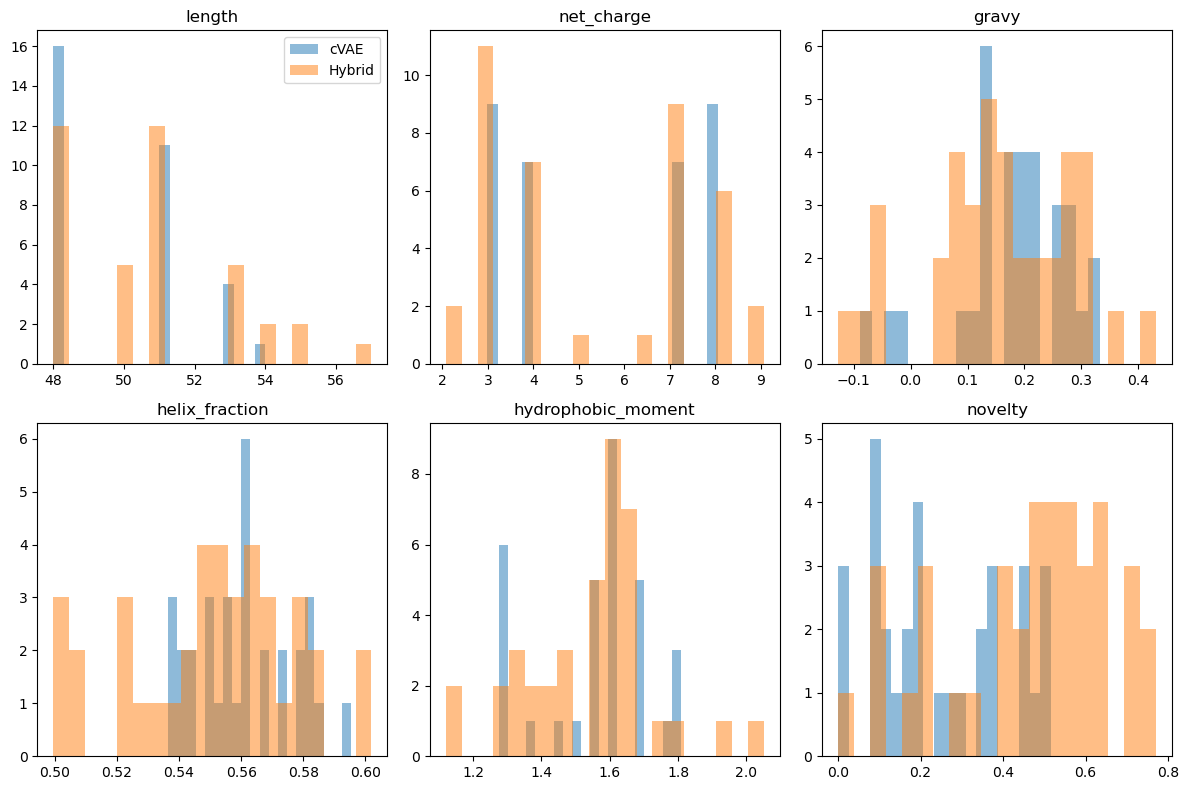

In [13]:
# ==== Cell 13: Quick plots ====
def quick_hist_overlays(df_a, df_b, name_a, name_b, metrics=None):
    if metrics is None:
        metrics = ["length","net_charge","gravy","helix_fraction","hydrophobic_moment","novelty"]
    fig, axs = plt.subplots(2,3, figsize=(12,8)); axs = axs.ravel()
    for i,m in enumerate(metrics):
        ax = axs[i]
        if (df_a is not None) and (not df_a.empty) and (m in df_a.columns):
            ax.hist(df_a[m], bins=20, alpha=0.5, label=name_a)
        if (df_b is not None) and (not df_b.empty) and (m in df_b.columns):
            ax.hist(df_b[m], bins=20, alpha=0.5, label=name_b)
        ax.set_title(m)
        if i==0: ax.legend()
    plt.tight_layout(); plt.show()

quick_hist_overlays(cvae_pass, hybrid_pass, "cVAE", "Hybrid")


In [ ]:
# Save a reproducible Methods JSON
import os, json, hashlib, platform, sys, datetime
import numpy as np

def file_sha256(path):
    try:
        h = hashlib.sha256()
        with open(path, "rb") as f:
            for chunk in iter(lambda: f.read(1<<20), b""):
                h.update(chunk)
        return h.hexdigest()
    except Exception:
        return None

cfg = TrainConfig() if 'TrainConfig' in globals() else None

methods = {
    "timestamp_utc": datetime.datetime.utcnow().isoformat() + "Z",
    "seed": globals().get("SEED"),
    "environment": {
        "python": sys.version.split()[0],
        "platform": platform.platform(),
        "torch": getattr(torch, "__version__", None),
        "cuda_available": torch.cuda.is_available(),
        "device": globals().get("DEVICE"),
        "numpy": getattr(np, "__version__", None),
        "pandas": getattr(pd, "__version__", None),
    },
    "data": {
        "source": globals().get("DATA_PATH"),
        "sha256": file_sha256(globals().get("DATA_PATH")) if globals().get("DATA_PATH") else None,
        "n_train_sequences": len(globals().get("train_sequences", [])),
        "max_len": globals().get("MAX_LEN"),
    },
    "tokenizer": {
        "alphabet": "".join(globals().get("AA", "")),
        "pad_idx": globals().get("PAD_IDX"),
        "bos_idx": globals().get("BOS_IDX"),
        "eos_idx": globals().get("EOS_IDX"),
    },
    "model": {
        "class": type(globals().get("model")).__name__ if globals().get("model") is not None else None,
        "params": {
            "vocab_size": getattr(globals().get("model"), "vocab_size", None),
            "d_model": getattr(globals().get("model"), "d_model", None),
            "z_dim": getattr(globals().get("model"), "z_dim", None),
            "c_dim": getattr(globals().get("model"), "c_dim", None),
        },
        "conditioning": {
            "FiLM": True,
            "CFG_uncond_p": getattr(cfg, "p_uncond", None) if cfg else None,
            "CFG_w": globals().get("CFG_W", 1.8),
        },
        "regularization": {
            "free_bits": getattr(cfg, "free_bits", None) if cfg else None,
            "label_smoothing": getattr(cfg, "label_smoothing", None) if cfg else None,
        },
    },
    "training": {
        "epochs": getattr(cfg, "epochs", None) if cfg else None,
        "lr": getattr(cfg, "lr", None) if cfg else None,
        "beta_max": getattr(cfg, "beta_max", None) if cfg else None,
        "cycle_epochs": getattr(cfg, "cycle_epochs", None) if cfg else None,
        "batch_size": getattr(globals().get("dl_tr", None), "batch_size", None),
        "n_train": len(globals().get("ds_tr", [])) if globals().get("ds_tr") is not None else None,
        "n_val": len(globals().get("ds_va", [])) if globals().get("ds_va") is not None else None,
    },
    "generation": {
        "target_props": globals().get("TARGET"),
        "n_raw_per_arm": globals().get("N_RAW"),
        "max_tries": globals().get("MAX_TRIES"),
        "cvae": {
            "batch_size": globals().get("C_VAE_BATCH"),
            "temperature": globals().get("TEMPERATURE"),
            "top_k": globals().get("TOP_K"),
            "CFG_w": globals().get("CFG_W", 1.8),
        },
        "interpolation": {
            "topk_parents": 30,
            "mut_p": 0.08,
            "target_len": int(round(globals().get("TARGET", {}).get("length", 50))) if globals().get("TARGET") else None,
        },
        "hybrid": { "polish_iters": globals().get("HYB_POLISH_ITERS") },
    },
    "filters": {
        "length_range": [35, 70],
        "net_charge_range": [2, 12],
        "gravy_range": [-1.2, 1.2],
        "helix_fraction_min": 0.45,
        "hydrophobic_moment_min": 0.8,
        "lm_nll_max": 3.5,
        "novelty_k": 3,
    },
    "scoring": {
        "ti_alpha": 0.7,
        "lm_bonus_rule": "bonus=(3.5 - lm_nll).clip(0,1.5)/15.0"
    },
    "outputs": {
        "interpolation": ["outputs/interpolation_pass.csv", "outputs/interpolation_pass.fasta"],
        "cvae": ["outputs/cvae_pass.csv", "outputs/cvae_pass.fasta"],
        "hybrid": ["outputs/hybrid_pass.csv", "outputs/hybrid_pass.fasta"],
        "summary": "outputs/summary_comparison.csv"
    }
}

os.makedirs("outputs", exist_ok=True)
with open("outputs/methods.json", "w") as f:
    json.dump(methods, f, indent=2)
print("Saved methods JSON → outputs/methods.json")


In [14]:
# =======================
# RESULTS SUMMARY: stats + diversity tables
# =======================
import numpy as np, pandas as pd, math
from collections import Counter, defaultdict

# -------- Expect these post-filter DataFrames to exist --------
for _name in ["interp_pass","cvae_pass","hybrid_pass"]:
    assert _name in globals(), f"Missing {_name}. Run the driver cell first."

# --------- Helpers (defined here to be self-contained) ---------
def stack_for_stats(interp_pass, cvae_pass, hybrid_pass):
    keep = ["sequence","activity","toxicity","novelty","helix_fraction","hydrophobic_moment","score"]
    frames = []
    for name, df in [("Interpolation", interp_pass), ("cVAE", cvae_pass), ("Hybrid", hybrid_pass)]:
        d = df[keep].copy()
        d["arm"] = name
        frames.append(d)
    return pd.concat(frames, ignore_index=True)

def _kruskal_H(groups):
    vals = np.concatenate(groups)
    ranks = pd.Series(vals).rank(method="average").to_numpy()
    N = len(vals)
    ties = pd.Series(vals).value_counts().to_numpy()
    tie_c = 1.0 - (np.sum(ties**3 - ties) / (N**3 - N)) if N > 1 else 1.0
    idx = 0; H_num = 0.0
    for g in groups:
        n = len(g); R = ranks[idx:idx+n].sum(); H_num += (R**2)/n; idx += n
    H = (12.0/(N*(N+1.0))) * H_num - 3.0*(N+1.0)
    return H / max(tie_c, 1e-12), tie_c

def kruskal_permutation_p(groups, n_perm=5000, seed=42):
    rng = np.random.default_rng(seed)
    groups = [np.asarray(g, dtype=float) for g in groups if len(g)]
    H_obs, _ = _kruskal_H(groups)
    lengths = [len(g) for g in groups]
    vals = np.concatenate(groups); N = len(vals)
    splits = np.cumsum(lengths)[:-1]
    count = 0
    for _ in range(n_perm):
        shuf = vals[rng.permutation(N)]
        parts = np.split(shuf, splits)
        H_perm, _ = _kruskal_H(parts)
        if H_perm >= H_obs - 1e-12: count += 1
    p = (count + 1) / (n_perm + 1)
    return H_obs, p

def omnibus_test(all_df, metric):
    groups = [all_df.loc[all_df.arm==arm, metric].dropna().to_numpy()
              for arm in ["Interpolation","cVAE","Hybrid"]]
    H, p = kruskal_permutation_p(groups, n_perm=5000)
    return {"metric": metric, "H": H, "p_perm": p, "k": len(groups)}

def perm_diff_means(a, b, n_perm=5000, seed=42):
    rng = np.random.default_rng(seed)
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    obs = a.mean() - b.mean()
    combined = np.concatenate([a,b]); nA = len(a); N = combined.size
    count = 0
    for _ in range(n_perm):
        diff = combined[rng.permutation(N)[:nA]].mean() - combined[rng.permutation(N)[nA:]].mean()
        if abs(diff) >= abs(obs) - 1e-12: count += 1
    p = (count + 1) / (n_perm + 1)
    return obs, p

def bootstrap_ci_diff(a, b, n_boot=5000, ci=95, seed=123):
    rng = np.random.default_rng(seed)
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    diffs = np.empty(n_boot)
    for i in range(n_boot):
        a_s = a[rng.integers(0, len(a), size=len(a))]
        b_s = b[rng.integers(0, len(b), size=len(b))]
        diffs[i] = a_s.mean() - b_s.mean()
    lo, hi = np.percentile(diffs, [(100-ci)/2, 100-(100-ci)/2])
    return float(lo), float(hi)

def bh_fdr(pvals, alpha=0.05):
    p = np.asarray(pvals); order = np.argsort(p); ranked = p[order]
    m = len(p); thresh = (np.arange(1, m+1) / m) * alpha
    passed = ranked <= thresh
    crit = ranked[passed].max() if passed.any() else 0.0
    return [pv <= crit for pv in p], crit

def pairwise_tests(all_df, metric):
    arms = ["Interpolation","cVAE","Hybrid"]
    data = {a: all_df.loc[all_df.arm==a, metric].dropna().to_numpy() for a in arms}
    pairs = [("Interpolation","cVAE"), ("Interpolation","Hybrid"), ("cVAE","Hybrid")]
    rows, pvals = [], []
    for a,b in pairs:
        diff, p = perm_diff_means(data[a], data[b], n_perm=5000)
        lo, hi = bootstrap_ci_diff(data[a], data[b], n_boot=5000)
        rows.append({"metric": metric, "pair": f"{a} vs {b}",
                     "diff_mean": diff, "p_perm": p, "ci95_lo": lo, "ci95_hi": hi})
        pvals.append(p)
    sig_flags, crit = bh_fdr(pvals, alpha=0.05)
    for i,flag in enumerate(sig_flags):
        rows[i]["fdr_sig"] = bool(flag); rows[i]["fdr_crit"] = crit
    return pd.DataFrame(rows)

# Diversity helpers
def lev_norm(a: str, b: str) -> float:
    if a == b: return 0.0
    n, m = len(a), len(b)
    if n == 0 or m == 0: return 1.0
    if n < m: a, b, n, m = b, a, m, n
    prev = np.arange(m+1)
    for i, ca in enumerate(a, 1):
        curr = np.empty(m+1, dtype=int); curr[0] = i
        for j, cb in enumerate(b, 1):
            cost = 0 if ca == cb else 1
            curr[j] = min(curr[j-1] + 1, prev[j] + 1, prev[j-1] + cost)
        prev = curr
    return prev[m] / max(n, m)

def sample_pairs(seqs, k=300, seed=7):
    rng = np.random.default_rng(seed); seqs = list(seqs)
    idx = np.arange(len(seqs)) if len(seqs) <= k else rng.choice(len(seqs), size=k, replace=False)
    sub = [seqs[i] for i in idx]
    pairs = []
    for i in range(len(sub)):
        for j in range(i+1, len(sub)):
            pairs.append((sub[i], sub[j]))
    return pairs

def within_arm_lev_dists(df, k=300, seed=7):
    if df is None or df.empty: return np.array([])
    pairs = sample_pairs(df["sequence"].tolist(), k=k, seed=seed)
    return np.array([lev_norm(a,b) for a,b in pairs], dtype=float)

def kmer_set(seq: str, k: int = 3) -> set:
    return set(seq[i:i+k] for i in range(len(seq)-k+1)) if len(seq) >= k else set()

def jaccard_dist(a: set, b: set) -> float:
    if not a and not b: return 0.0
    inter = len(a & b); union = len(a | b)
    return 1.0 - (inter/union if union else 0.0)

def greedy_cluster(seqs, k=3, thresh=0.7, max_items=300, seed=13):
    rng = np.random.default_rng(seed)
    seqs = list(seqs)
    if len(seqs) == 0: return [], [], []
    if len(seqs) > max_items:
        idx = rng.choice(len(seqs), size=max_items, replace=False)
        seqs = [seqs[i] for i in idx]
    kmers = [kmer_set(s, k=k) for s in seqs]
    clusters = []
    for i, s_k in enumerate(kmers):
        placed = False
        for cl in clusters:
            if min(jaccard_dist(s_k, kmers[j]) for j in cl) <= thresh:
                cl.append(i); placed = True; break
        if not placed: clusters.append([i])
    sizes = [len(c) for c in clusters]
    return clusters, sizes, seqs

# --------- Build stats tables ---------
all_df = stack_for_stats(interp_pass, cvae_pass, hybrid_pass)
metrics = ["activity","toxicity","novelty","helix_fraction","hydrophobic_moment","score"]

# Omnibus
omni_rows = [omnibus_test(all_df, m) for m in metrics]
omnibus_table = pd.DataFrame(omni_rows).sort_values("p_perm")

# Pairwise
pairwise_tables = [pairwise_tests(all_df, m) for m in metrics]
pairwise_table = pd.concat(pairwise_tables, ignore_index=True)
pairwise_table = pairwise_table.sort_values(["metric","p_perm"])

# Diversity summaries
def div_summary(df, name):
    lev = within_arm_lev_dists(df, k=300)
    clusters, sizes, subs = greedy_cluster(df["sequence"] if df is not None and not df.empty else [], 
                                           k=3, thresh=0.7, max_items=300)
    return {
        "arm": name,
        "n_pass": 0 if df is None else len(df),
        "lev_mean": float(np.mean(lev)) if len(lev) else np.nan,
        "lev_median": float(np.median(lev)) if len(lev) else np.nan,
        "clusters": len(clusters),
        "subsamp_size": len(subs),
        "median_cluster_size": float(np.median(sizes)) if len(sizes) else np.nan,
        "singletons": int(np.sum(np.array(sizes)==1)) if len(sizes) else 0
    }

div_table = pd.DataFrame([
    div_summary(interp_pass, "Interpolation"),
    div_summary(cvae_pass,   "cVAE"),
    div_summary(hybrid_pass, "Hybrid"),
])

# --------- Display ---------
print("=== Omnibus (Kruskal–Wallis with permutation p) ===")
display(omnibus_table)

print("\n=== Pairwise permutation tests (diff of means) with BH-FDR and 95% bootstrap CIs ===")
display(pairwise_table)

print("\n=== Diversity summary (within-arm Levenshtein; k-mer Jaccard clustering) ===")
display(div_table)


=== Omnibus (Kruskal–Wallis with permutation p) ===


,metric,H,p_perm,k
3,helix_fraction,33.822052,0.000200,3
2,novelty,64.312811,0.000200,3
0,activity,4.704815,0.092781,3
1,toxicity,4.760592,0.093181,3
5,score,4.154622,0.118376,3
4,hydrophobic_moment,3.491431,0.176765,3



=== Pairwise permutation tests (diff of means) with BH-FDR and 95% bootstrap CIs ===


,metric,pair,diff_mean,p_perm,ci95_lo,ci95_hi,fdr_sig,fdr_crit
1,activity,Interpolation vs Hybrid,0.020247,0.021796,-0.002158,0.042760,False,0.000000
2,activity,cVAE vs Hybrid,0.011414,0.360928,-0.023680,0.044826,False,0.000000
0,activity,Interpolation vs cVAE,0.008832,0.381124,-0.015774,0.034072,False,0.000000
9,helix_fraction,Interpolation vs cVAE,-0.022610,0.000200,-0.028272,-0.017006,True,0.008798
10,helix_fraction,Interpolation vs Hybrid,-0.012421,0.004599,-0.020739,-0.003782,True,0.008798
11,helix_fraction,cVAE vs Hybrid,0.010189,0.008798,0.000482,0.020171,True,0.008798
12,hydrophobic_moment,Interpolation vs cVAE,-0.077602,0.095181,-0.133057,-0.017198,False,0.000000
13,hydrophobic_moment,Interpolation vs Hybrid,-0.064326,0.124975,-0.125634,-0.003468,False,0.000000
14,hydrophobic_moment,cVAE vs Hybrid,0.013276,0.667267,-0.071202,0.093457,False,0.000000
6,novelty,Interpolation vs cVAE,0.294249,0.000200,0.238339,0.351298,True,0.001200



=== Diversity summary (within-arm Levenshtein; k-mer Jaccard clustering) ===


,arm,n_pass,lev_mean,lev_median,clusters,subsamp_size,median_cluster_size,singletons
0,Interpolation,1991,0.603010,0.653846,87,300,1.0,69
1,cVAE,32,0.352051,0.509804,2,32,16.0,0
2,Hybrid,39,0.436723,0.450980,3,39,6.0,1


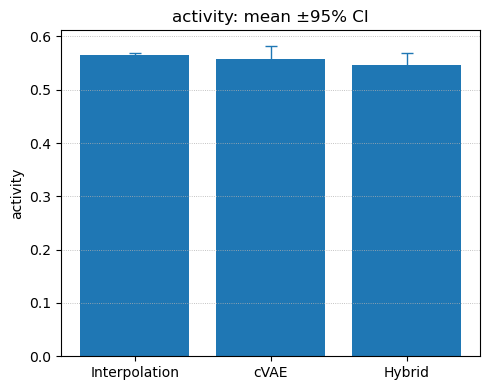

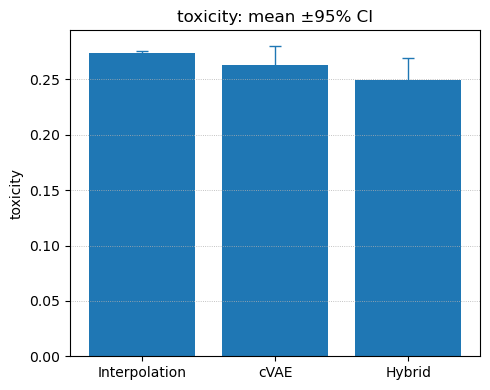

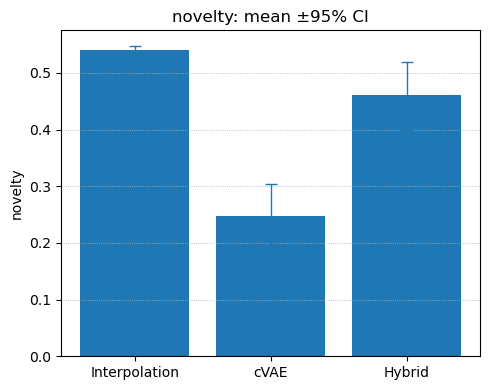

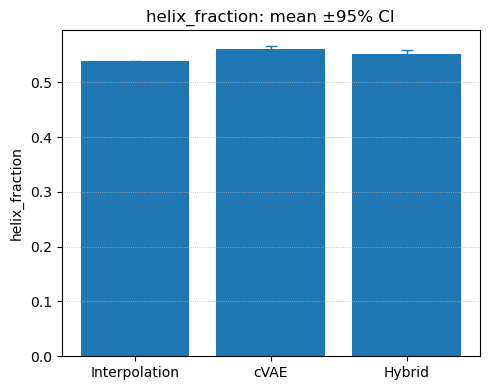

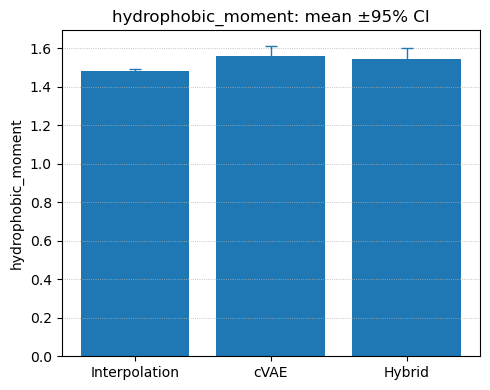

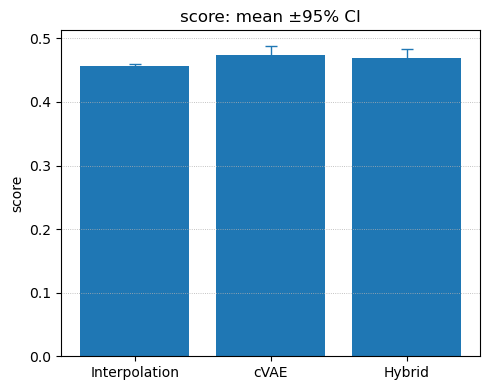

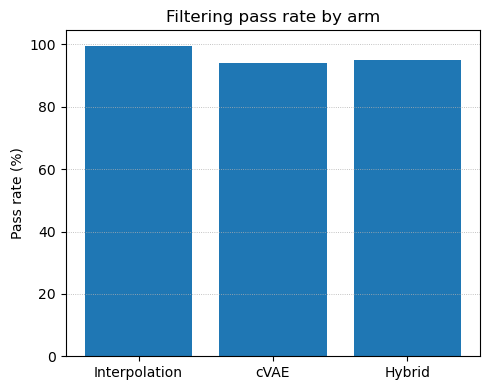

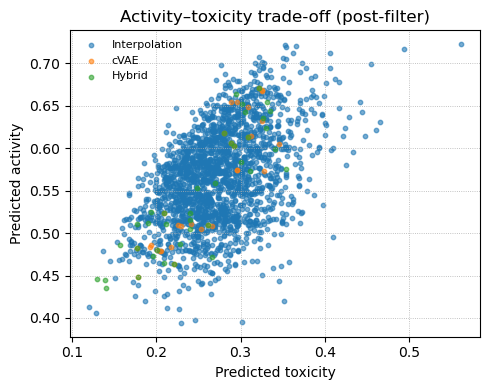

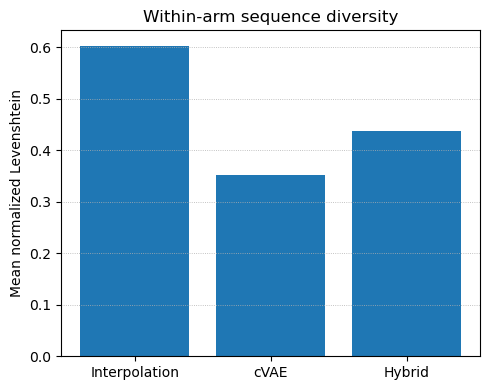

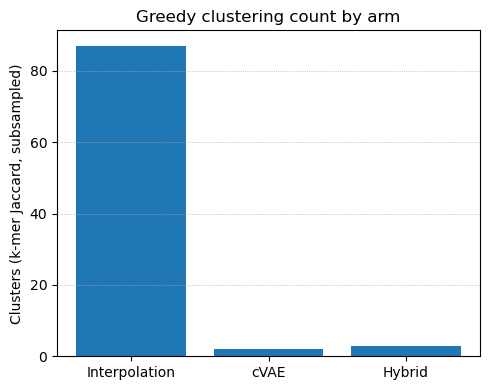

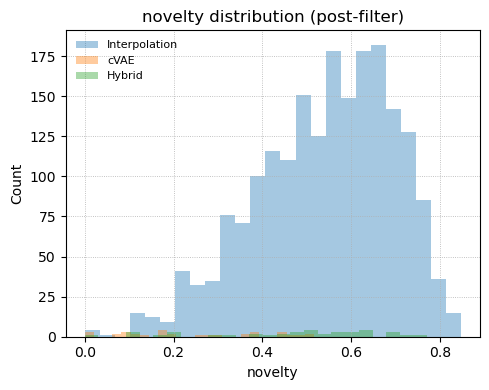

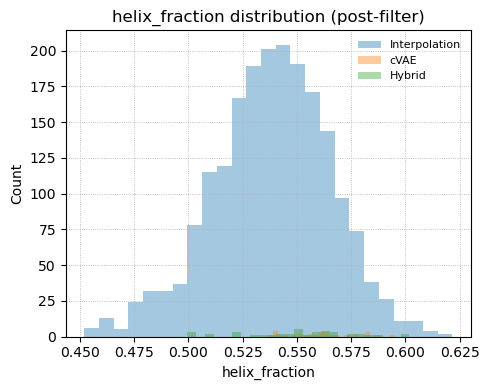

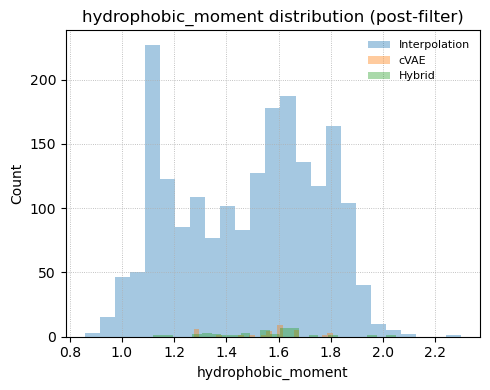

Saved figures to 'outputs/' as both PNG and PDF.


In [15]:
# =======================
# Publication-quality plots (matplotlib-only, one chart per figure)
# =======================
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

os.makedirs("outputs", exist_ok=True)

ARMS = ["Interpolation","cVAE","Hybrid"]
METRICS = ["activity","toxicity","novelty","helix_fraction","hydrophobic_moment","score"]

def bootstrap_mean_ci(x, n_boot=5000, ci=95, seed=123):
    x = np.asarray(x, dtype=float)
    x = x[~np.isnan(x)]
    if len(x) == 0:
        return np.nan, (np.nan, np.nan)
    rng = np.random.default_rng(seed)
    boots = np.empty(n_boot)
    n = len(x)
    for i in range(n_boot):
        s = x[rng.integers(0, n, size=n)]
        boots[i] = np.mean(s)
    lo, hi = np.percentile(boots, [(100-ci)/2, 100-(100-ci)/2])
    return float(np.mean(x)), (float(lo), float(hi))

def bar_with_ci(ax, labels, means, ci_los, ci_his, ylabel, title):
    x = np.arange(len(labels))
    ax.bar(x, means)
    ax.errorbar(x, means, yerr=[np.array(means)-np.array(ci_los), np.array(ci_his)-np.array(means)],
                fmt='none', capsize=4, linewidth=1)
    ax.set_xticks(x); ax.set_xticklabels(labels, rotation=0)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, axis='y', linestyle=':', linewidth=0.6)

def savefig(name):
    plt.tight_layout()
    plt.savefig(f"outputs/{name}.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"outputs/{name}.pdf", bbox_inches="tight")
    plt.show()

# 1) Per-metric bar charts (mean ± 95% bootstrap CI) for each arm
for m in METRICS:
    means, los, his = [], [], []
    for arm in ARMS:
        vals = all_df.loc[all_df.arm==arm, m].astype(float).values
        mean, (lo, hi) = bootstrap_mean_ci(vals)
        means.append(mean); los.append(lo); his.append(hi)
    fig, ax = plt.subplots(figsize=(5,4))
    bar_with_ci(ax, ARMS, means, los, his, ylabel=m, title=f"{m}: mean ±95% CI")
    savefig(f"fig_{m}_mean_ci_by_arm")

# 2) Pass rate bar chart
def pass_rate(df_raw, df_pass):
    num = len(df_pass) if df_pass is not None else 0
    den = len(df_raw) if df_raw is not None else 1
    return 100.0 * num / max(1, den)

rates = [
    pass_rate(globals().get("interp_raw"), globals().get("interp_pass")),
    pass_rate(globals().get("cvae_raw"),   globals().get("cvae_pass")),
    pass_rate(globals().get("hybrid_raw"), globals().get("hybrid_pass")),
]
fig, ax = plt.subplots(figsize=(5,4))
ax.bar(ARMS, rates)
ax.set_ylabel("Pass rate (%)")
ax.set_title("Filtering pass rate by arm")
ax.grid(True, axis='y', linestyle=':', linewidth=0.6)
savefig("fig_pass_rate_by_arm")

# 3) Trade-off scatter: Activity vs. Toxicity (post-filter)
def scatter_tradeoff(df, name, ax):
    if df is None or df.empty: 
        return
    ax.scatter(df["toxicity"].values, df["activity"].values, s=10, alpha=0.6, label=name)

fig, ax = plt.subplots(figsize=(5,4))
scatter_tradeoff(interp_pass, "Interpolation", ax)
scatter_tradeoff(cvae_pass,   "cVAE",         ax)
scatter_tradeoff(hybrid_pass, "Hybrid",       ax)
ax.set_xlabel("Predicted toxicity")
ax.set_ylabel("Predicted activity")
ax.set_title("Activity–toxicity trade-off (post-filter)")
ax.legend(frameon=False, fontsize=8)
ax.grid(True, linestyle=':', linewidth=0.6)
savefig("fig_activity_vs_toxicity_scatter")

# 4) Diversity: within-arm normalized Levenshtein means (from div_table)
#    (Assumes you ran the stats/diversity summary cell to create `div_table`.)
if "div_table" in globals() and isinstance(div_table, pd.DataFrame) and not div_table.empty:
    dv = div_table.set_index("arm").reindex(ARMS)
    fig, ax = plt.subplots(figsize=(5,4))
    ax.bar(ARMS, dv["lev_mean"].values.astype(float))
    ax.set_ylabel("Mean normalized Levenshtein")
    ax.set_title("Within-arm sequence diversity")
    ax.grid(True, axis='y', linestyle=':', linewidth=0.6)
    savefig("fig_diversity_levenshtein_by_arm")

    # Cluster count bar
    fig, ax = plt.subplots(figsize=(5,4))
    ax.bar(ARMS, dv["clusters"].values.astype(float))
    ax.set_ylabel("Clusters (k-mer Jaccard, subsampled)")
    ax.set_title("Greedy clustering count by arm")
    ax.grid(True, axis='y', linestyle=':', linewidth=0.6)
    savefig("fig_diversity_clusters_by_arm")

# 5) Distribution overlays (optional): histograms per arm for a couple of key metrics
def hist_overlay(metric, bins=25):
    fig, ax = plt.subplots(figsize=(5,4))
    for arm, df in [("Interpolation", interp_pass), ("cVAE", cvae_pass), ("Hybrid", hybrid_pass)]:
        if df is None or df.empty or metric not in df.columns: 
            continue
        ax.hist(df[metric].values.astype(float), bins=bins, alpha=0.4, label=arm)
    ax.set_xlabel(metric); ax.set_ylabel("Count")
    ax.set_title(f"{metric} distribution (post-filter)")
    ax.legend(frameon=False, fontsize=8)
    ax.grid(True, linestyle=':', linewidth=0.6)
    savefig(f"fig_{metric}_hist_overlay")

for metric in ["novelty","helix_fraction","hydrophobic_moment"]:
    hist_overlay(metric)

print("Saved figures to 'outputs/' as both PNG and PDF.")
